# __Training and tuning neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, October, 2023

## Main goals:


__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

### Auxiliary functions

In [4]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [5]:
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [6]:
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('Área curva ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='aleatório', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RNA', color='blue')
    
    # axis labels
    pyplot.xlabel('Taxa de falso positivo')
    pyplot.ylabel('Taxa de verdadeiro positivo')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [7]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [8]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

### Obtaining and visualize the dataset

In [9]:
APP_PATH = os.getcwd()

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
#file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_nocorrencias_1km_shuffled.csv"
#file = "pt_nocorrencias_2km_shuffled.csv"
#file = "pt_nocorrencias_3km_shuffled.csv"
#file = "pt_nocorrencias_4km_shuffled.csv"

file = "guaruja_shuffled.csv"


dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [10]:
dataset.shape

(200, 11)

In [11]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,100.50,375351.60,7350229.58,14.42,0.03,23.94,64.32,209.79,32.56,75.80,0.5
std,57.88,4313.00,4368.70,13.62,0.41,11.79,56.08,103.92,31.56,26.72,0.5
min,1.00,365857.79,7341789.72,0.09,-0.59,0.09,0.23,0.04,2.00,20.00,0.0
25%,50.75,372179.26,7346972.48,4.29,-0.01,18.08,14.33,121.04,2.00,90.00,0.0
50%,100.50,375219.03,7349677.08,6.13,-0.00,25.33,54.48,202.74,2.00,90.00,0.0
75%,150.25,379116.73,7354032.25,26.33,0.00,30.77,94.71,316.40,65.00,90.00,1.0
max,200.00,383738.84,7359892.24,69.73,4.30,69.73,226.06,359.51,65.00,90.00,1.0


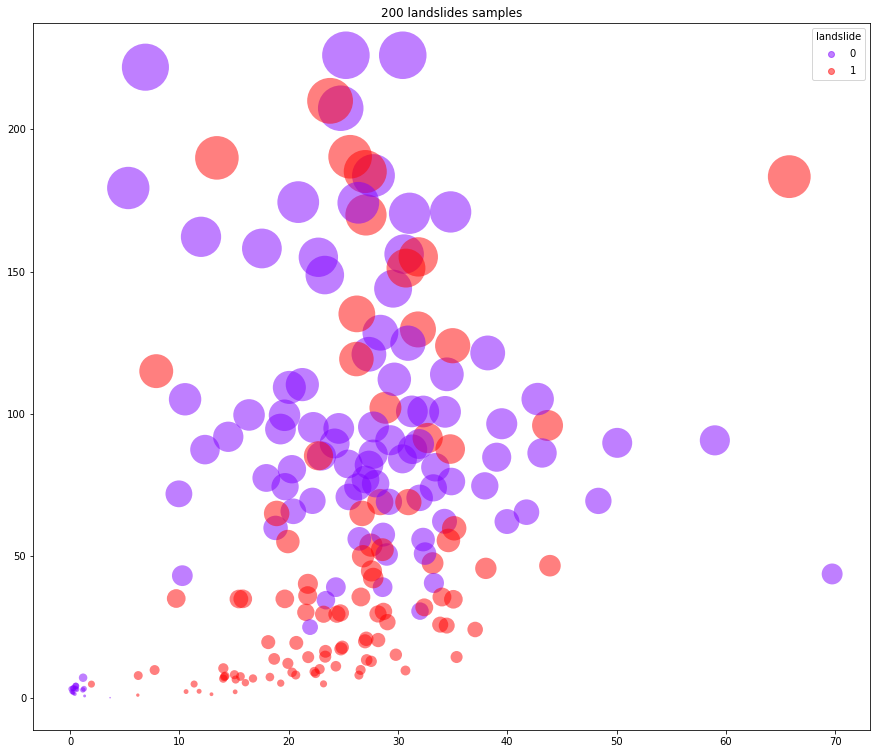

In [12]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.title.set_text("{}{}".format(len(dataset.index), ' landslides samples')) 

plt.show()

### DataPrep
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

In [13]:
#features menos relevantes guaruja
#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('curv',axis=1)
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('uso_solo',axis=1)
# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]
dataset.head(5)

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [14]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation2(dataset)
#X_train, X_test, y_train, y_test = dataPreparation(dataset)

In [15]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [16]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [17]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [18]:
X.shape

(200, 7)

In [19]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [20]:
y.shape

(200, 1)

In [21]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


__Computa o número de variáveis de entrada (features) e saída (sempre 1)__

In [22]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- custom classes and functions

In [23]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [24]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [25]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [26]:
# (batch_size) implementa o mini-batch que acelera o tempo de treinamento, requer método de inicialização do mini-batch. 
#ideal que o batch_size seja multiplo do tamanho do conjunto de dados de treinamento, que aqui é de 128 
neurons = [7,8,12] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [27]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Input layer: {} inputs neurons  {} outputs neurons {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' hidden layer {} neurons {} layers '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} last hidden layer neurons, {} output neurons \033[0m'.format(neurons,output_dim))

In [28]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.91581926 + 0.00000000 = 0.91581926 loss_val = 0.91581926
epoch: 3000/40000 loss_train: 0.44204050 + 0.00000000 = 0.44204050 loss_val = 0.44204050
epoch: 6000/40000 loss_train: 0.26252012 + 0.00000000 = 0.26252012 loss_val = 0.26252012
epoch: 9000/40000 loss_train: 0.17858602 + 0.00000000 = 0.17858602 loss_val = 0.17858602
epoch: 12000/40000 loss_train: 0.14052217 + 0.00000000 = 0.14052217 loss_val = 0.14052217
epoch: 15000/40000 loss_train: 0.12161384 + 0.00000000 = 0.12161384 loss_val = 0.12161384
epoch: 18000/40000 loss_train: 0.11077174 + 0.00000000 = 0.11077174 loss_val = 0.11077174
epoch: 21000/40000 loss_train: 0.10377310 + 0.00000000 = 0.10377310 loss_val = 0.10377310
epoch: 24000/40000 loss_train: 0.09877610 + 0.00000000 = 0.09877610 loss_val = 0.09877610
epoch: 27000/40000 loss_train: 0.09487298 + 0.00000000 = 0.09487298 loss_val = 0.09487298
epoch: 30000/40000 loss_train: 0.09165844 + 0.00000000 = 0.09165844 loss_val = 0.09165844
epoch: 33000/4

epoch: 12000/40000 loss_train: 0.02960711 + 0.00000000 = 0.02960711 loss_val = 0.02960711
epoch: 15000/40000 loss_train: 0.02397953 + 0.00000000 = 0.02397953 loss_val = 0.02397953
epoch: 18000/40000 loss_train: 0.01977478 + 0.00000000 = 0.01977478 loss_val = 0.01977478
epoch: 21000/40000 loss_train: 0.01652365 + 0.00000000 = 0.01652365 loss_val = 0.01652365
epoch: 24000/40000 loss_train: 0.01408075 + 0.00000000 = 0.01408075 loss_val = 0.01408075
epoch: 27000/40000 loss_train: 0.01208138 + 0.00000000 = 0.01208138 loss_val = 0.01208138
epoch: 30000/40000 loss_train: 0.01045161 + 0.00000000 = 0.01045161 loss_val = 0.01045161
epoch: 33000/40000 loss_train: 0.00910182 + 0.00000000 = 0.00910182 loss_val = 0.00910182
epoch: 36000/40000 loss_train: 0.00797481 + 0.00000000 = 0.00797481 loss_val = 0.00797481
epoch: 39000/40000 loss_train: 0.00703280 + 0.00000000 = 0.00703280 loss_val = 0.00703280
To 7 neurons, 1 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 10

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 1 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.89714862 + 0.00000000 = 0.89714862 loss_val = 0.89714862
epoch: 3000/40000 loss_train: 0.21372324 + 0.00000000 = 0.21372324 loss_val = 0.21372324
epoch: 6000/40000 loss_train: 0.06554857 + 0.00000000 = 0.06554857 loss_val = 0.06554857
epoch: 9000/40000 loss_train: 0.03936628 + 0.00000000 = 0.03936628 loss_val = 0.03936628
epoch: 12000/40000 loss_train: 0.02806637 + 0.00000000 = 0.02806637 loss_val = 0.02806637
epoch: 15000/40000 loss_train: 0.02179957 + 0.00000000 = 0.02179957 loss_val = 0.02179957
epoch: 18000/40000 loss_train: 0.01721455 + 0.00000000 = 0.01721455 loss_val = 0.01721455
epoch: 21000/40000 loss_train: 0.01365825 + 0.00000000 = 0.01365825 loss_val = 0.01365825
epoch: 24000/40000 loss_train: 0.01112580 + 0.00000000 = 0.01112580 loss_val = 0.01112580
epoch: 27000/40000 loss_train: 0.00927417 + 0.00000000 = 0.00927417 loss_val = 0.0092741

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.87995259 + 0.00000000 = 0.87995259 loss_val = 0.87995259
epoch: 3000/40000 loss_train: 0.09486276 + 0.00000000 = 0.09486276 loss_val = 0.09486276
epoch: 6000/40000 loss_train: 0.08123011 + 0.00000000 = 0.08123011 loss_val = 0.08123011
epoch: 9000/40000 loss_train: 0.07836170 + 0.00000000 = 0.07836170 loss_val = 0.07836170
epoch: 12000/40000 loss_train: 0.07754007 + 0.00000000 = 0.07754007 loss_val = 0.07754007
epoch: 15000/40000 loss_train: 0.07726326 + 0.00000000 = 0.07726326 loss_val = 0.07726326
epoch: 18000/40000 loss_train: 0.07713865 + 0.00000000 = 0.07713865 loss_val = 0.07713865
epoch: 21000/40000 loss_train: 0.07688534 + 0.00000000 = 0.07688534 loss_val = 0.07688534
epoch: 24000/40000 loss_train: 0.07654525 + 0.00000000 = 0.07654525 loss_val = 0.07654525
epoch: 27000/40000 loss_train: 0.07611210 + 0.00000000 = 0.07611210 loss_val = 0.076112

epoch: 3000/40000 loss_train: 0.46189387 + 0.00000000 = 0.46189387 loss_val = 0.46189387
epoch: 6000/40000 loss_train: 0.31693185 + 0.00000000 = 0.31693185 loss_val = 0.31693185
epoch: 9000/40000 loss_train: 0.21913910 + 0.00000000 = 0.21913910 loss_val = 0.21913910
epoch: 12000/40000 loss_train: 0.16136744 + 0.00000000 = 0.16136744 loss_val = 0.16136744
epoch: 15000/40000 loss_train: 0.12834738 + 0.00000000 = 0.12834738 loss_val = 0.12834738
epoch: 18000/40000 loss_train: 0.10834210 + 0.00000000 = 0.10834210 loss_val = 0.10834210
epoch: 21000/40000 loss_train: 0.09510648 + 0.00000000 = 0.09510648 loss_val = 0.09510648
epoch: 24000/40000 loss_train: 0.08572979 + 0.00000000 = 0.08572979 loss_val = 0.08572979
epoch: 27000/40000 loss_train: 0.07794481 + 0.00000000 = 0.07794481 loss_val = 0.07794481
epoch: 30000/40000 loss_train: 0.07141461 + 0.00000000 = 0.07141461 loss_val = 0.07141461
epoch: 33000/40000 loss_train: 0.06606361 + 0.00000000 = 0.06606361 loss_val = 0.06606361
epoch: 36000/

epoch: 6000/40000 loss_train: 0.07558969 + 0.00000000 = 0.07558969 loss_val = 0.07558969
epoch: 9000/40000 loss_train: 0.05934906 + 0.00000000 = 0.05934906 loss_val = 0.05934906
epoch: 12000/40000 loss_train: 0.04924238 + 0.00000000 = 0.04924238 loss_val = 0.04924238
epoch: 15000/40000 loss_train: 0.04175673 + 0.00000000 = 0.04175673 loss_val = 0.04175673
epoch: 18000/40000 loss_train: 0.03554668 + 0.00000000 = 0.03554668 loss_val = 0.03554668
epoch: 21000/40000 loss_train: 0.03001113 + 0.00000000 = 0.03001113 loss_val = 0.03001113
epoch: 24000/40000 loss_train: 0.02524484 + 0.00000000 = 0.02524484 loss_val = 0.02524484
epoch: 27000/40000 loss_train: 0.02116456 + 0.00000000 = 0.02116456 loss_val = 0.02116456
epoch: 30000/40000 loss_train: 0.01771622 + 0.00000000 = 0.01771622 loss_val = 0.01771622
epoch: 33000/40000 loss_train: 0.01486614 + 0.00000000 = 0.01486614 loss_val = 0.01486614
epoch: 36000/40000 loss_train: 0.01254178 + 0.00000000 = 0.01254178 loss_val = 0.01254178
epoch: 39000

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.84238170 + 0.00000000 = 0.84238170 loss_val = 0.84238170
epoch: 3000/40000 loss_train: 0.08660404 + 0.00000000 = 0.08660404 loss_val = 0.08660404
epoch: 6000/40000 loss_train: 0.05397221 + 0.00000000 = 0.05397221 loss_val = 0.05397221
To 8 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.91223618 + 0.00000000 = 0.91223618 loss_val = 0.91223618
epoch: 3000/40000 loss_train: 0.32652395 + 0.00000000 = 0.32652395 loss_val = 0.32652395
epoch: 6000/40000 loss_train: 0.18776846 + 0.00000000 = 0.18776846 loss_val = 0.18776846
epoch: 9000/40000 loss_train: 0.13730061 + 0.00000000 = 0.13730061 loss_val = 0.13730061
epoch: 12000/40000 loss_train: 0.11645597 + 0.00000000 = 0.11645597 loss_val = 0.11645597
epoch: 15000/40000 loss_train: 0.10552158 + 0.00000000 = 0.10552158 loss_va

epoch: 33000/40000 loss_train: 0.07907802 + 0.00000000 = 0.07907802 loss_val = 0.07907802
epoch: 36000/40000 loss_train: 0.07596935 + 0.00000000 = 0.07596935 loss_val = 0.07596935
epoch: 39000/40000 loss_train: 0.07330457 + 0.00000000 = 0.07330457 loss_val = 0.07330457
To 12 neurons, 1 layer(s),  0.001 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.61548004 + 0.00000000 = 0.61548004 loss_val = 0.61548004
epoch: 3000/40000 loss_train: 0.13253815 + 0.00000000 = 0.13253815 loss_val = 0.13253815
epoch: 6000/40000 loss_train: 0.06004021 + 0.00000000 = 0.06004021 loss_val = 0.06004021
epoch: 9000/40000 loss_train: 0.04009710 + 0.00000000 = 0.04009710 loss_val = 0.04009710
epoch: 12000/40000 loss_train: 0.03025560 + 0.00000000 = 0.03025560 loss_val = 0.03025560
epoch: 15000/40000 loss_train: 0.02463216 + 0.00000000 = 0.02463216 loss_val = 0.02463216
epoch: 18000/40000 loss_train: 0.02066402 + 0.00000000 = 0.02066402 loss_val = 0.0206

epoch: 24000/40000 loss_train: 0.00418557 + 0.00000000 = 0.00418557 loss_val = 0.00418557
epoch: 27000/40000 loss_train: 0.00342221 + 0.00000000 = 0.00342221 loss_val = 0.00342221
epoch: 30000/40000 loss_train: 0.00285875 + 0.00000000 = 0.00285875 loss_val = 0.00285875
epoch: 33000/40000 loss_train: 0.00243137 + 0.00000000 = 0.00243137 loss_val = 0.00243137
epoch: 36000/40000 loss_train: 0.00209934 + 0.00000000 = 0.00209934 loss_val = 0.00209934
epoch: 39000/40000 loss_train: 0.00183642 + 0.00000000 = 0.00183642 loss_val = 0.00183642
To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 1.33070700 + 0.00000000 = 1.33070700 loss_val = 1.33070700
epoch: 3000/40000 loss_train: 0.07797549 + 0.00000000 = 0.07797549 loss_val = 0.07797549
epoch: 6000/40000 loss_train: 0.05524876 + 0.00000000 = 0.05524876 loss_val = 0.05524876
To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have

epoch: 33000/40000 loss_train: 0.19367384 + 0.00000000 = 0.19367384 loss_val = 0.19367384
epoch: 36000/40000 loss_train: 0.17434300 + 0.00000000 = 0.17434300 loss_val = 0.17434300
epoch: 39000/40000 loss_train: 0.09993447 + 0.00000000 = 0.09993447 loss_val = 0.09993447
To 7 neurons, 2 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.73448491 + 0.00000000 = 0.73448491 loss_val = 0.73448491
epoch: 3000/40000 loss_train: 0.61040304 + 0.00000000 = 0.61040304 loss_val = 0.61040304
epoch: 6000/40000 loss_train: 0.46569569 + 0.00000000 = 0.46569569 loss_val = 0.46569569
epoch: 9000/40000 loss_train: 0.31926158 + 0.00000000 = 0.31926158 loss_val = 0.31926158
epoch: 12000/40000 loss_train: 0.22456361 + 0.00000000 = 0.22456361 loss_val = 0.22456361
To 7 neurons, 2 layer(s),  0.001 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 92.86% 
epoch:    0/40000 loss_train: 0.62635976 + 0.00000000 = 0.62635976 los

epoch: 39000/40000 loss_train: 0.00106202 + 0.00000000 = 0.00106202 loss_val = 0.00106202
To 7 neurons, 2 layer(s),  0.005 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.90286889 + 0.00000000 = 0.90286889 loss_val = 0.90286889
epoch: 3000/40000 loss_train: 0.25141813 + 0.00000000 = 0.25141813 loss_val = 0.25141813
To 7 neurons, 2 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 88.10% 
epoch:    0/40000 loss_train: 0.86213285 + 0.00000000 = 0.86213285 loss_val = 0.86213285
epoch: 3000/40000 loss_train: 0.07854063 + 0.00000000 = 0.07854063 loss_val = 0.07854063
epoch: 6000/40000 loss_train: 0.06144348 + 0.00000000 = 0.06144348 loss_val = 0.06144348
epoch: 9000/40000 loss_train: 0.05495006 + 0.00000000 = 0.05495006 loss_val = 0.05495006
epoch: 12000/40000 loss_train: 0.05259635 + 0.00000000 = 0.05259635 loss_val = 0.05259635
epoch: 15000/40000 loss_train: 0.05101570 + 0.00000000 = 0.05101570 los

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.87882527 + 0.00000000 = 0.87882527 loss_val = 0.87882527
epoch: 3000/40000 loss_train: 0.04002011 + 0.00000000 = 0.04002011 loss_val = 0.04002011
epoch: 6000/40000 loss_train: 0.01068692 + 0.00000000 = 0.01068692 loss_val = 0.01068692
To 7 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.83718726 + 0.00000000 = 0.83718726 loss_val = 0.83718726
epoch: 3000/40000 loss_train: 0.05158678 + 0.00000000 = 0.05158678 loss_val = 0.05158678
epoch: 6000/40000 loss_train: 0.02685266 + 0.00000000 = 0.02685266 loss_val = 0.02685266
epoch: 9000/40000 loss_train: 0.01370478 + 0.00000000 = 0.01370478 loss_val = 0.01370478
epoch: 12000/40000 loss_train: 0.00692727 + 0.00000000 = 0.00692727 loss_val = 0.00692727
epoch: 15000/40000 loss_train: 0.00385334 + 0.00000000 = 0.00385334 loss_va

epoch: 30000/40000 loss_train: 0.18588070 + 0.00000000 = 0.18588070 loss_val = 0.18588070
epoch: 33000/40000 loss_train: 0.17055663 + 0.00000000 = 0.17055663 loss_val = 0.17055663
epoch: 36000/40000 loss_train: 0.15267224 + 0.00000000 = 0.15267224 loss_val = 0.15267224
epoch: 39000/40000 loss_train: 0.13204156 + 0.00000000 = 0.13204156 loss_val = 0.13204156
To 8 neurons, 2 layer(s),  0.001 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 88.10% 
epoch:    0/40000 loss_train: 1.07987663 + 0.00000000 = 1.07987663 loss_val = 1.07987663
epoch: 3000/40000 loss_train: 0.65604732 + 0.00000000 = 0.65604732 loss_val = 0.65604732
epoch: 6000/40000 loss_train: 0.54501267 + 0.00000000 = 0.54501267 loss_val = 0.54501267
epoch: 9000/40000 loss_train: 0.33754962 + 0.00000000 = 0.33754962 loss_val = 0.33754962
epoch: 12000/40000 loss_train: 0.19650613 + 0.00000000 = 0.19650613 loss_val = 0.19650613
epoch: 15000/40000 loss_train: 0.14264754 + 0.00000000 = 0.14264754 loss_val = 0.1426475

To 8 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.77881018 + 0.00000000 = 0.77881018 loss_val = 0.77881018
epoch: 3000/40000 loss_train: 0.04720391 + 0.00000000 = 0.04720391 loss_val = 0.04720391
epoch: 6000/40000 loss_train: 0.02073610 + 0.00000000 = 0.02073610 loss_val = 0.02073610
To 8 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.75475392 + 0.00000000 = 0.75475392 loss_val = 0.75475392
epoch: 3000/40000 loss_train: 0.17115181 + 0.00000000 = 0.17115181 loss_val = 0.17115181
epoch: 6000/40000 loss_train: 0.06997756 + 0.00000000 = 0.06997756 loss_val = 0.06997756
epoch: 9000/40000 loss_train: 0.03452200 + 0.00000000 = 0.03452200 loss_val = 0.03452200
epoch: 12000/40000 loss_train: 0.01539702 + 0.00000000 = 0.01539702 loss_val = 0.01539702
epoch: 15000/40000 loss_train: 0.00780703 + 0.00000000 = 0.00780703 loss_v

epoch: 3000/40000 loss_train: 0.61354789 + 0.00000000 = 0.61354789 loss_val = 0.61354789
epoch: 6000/40000 loss_train: 0.38872004 + 0.00000000 = 0.38872004 loss_val = 0.38872004
epoch: 9000/40000 loss_train: 0.22342302 + 0.00000000 = 0.22342302 loss_val = 0.22342302
epoch: 12000/40000 loss_train: 0.15474628 + 0.00000000 = 0.15474628 loss_val = 0.15474628
epoch: 15000/40000 loss_train: 0.11905765 + 0.00000000 = 0.11905765 loss_val = 0.11905765
epoch: 18000/40000 loss_train: 0.10400495 + 0.00000000 = 0.10400495 loss_val = 0.10400495
epoch: 21000/40000 loss_train: 0.09440725 + 0.00000000 = 0.09440725 loss_val = 0.09440725
epoch: 24000/40000 loss_train: 0.08694946 + 0.00000000 = 0.08694946 loss_val = 0.08694946
To 12 neurons, 2 layer(s),  0.001 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.66801478 + 0.00000000 = 0.66801478 loss_val = 0.66801478
epoch: 3000/40000 loss_train: 0.40486545 + 0.00000000 = 0.40486545 loss_val = 0.40486

epoch: 3000/40000 loss_train: 0.09481276 + 0.00000000 = 0.09481276 loss_val = 0.09481276
epoch: 6000/40000 loss_train: 0.04120322 + 0.00000000 = 0.04120322 loss_val = 0.04120322
epoch: 9000/40000 loss_train: 0.02155904 + 0.00000000 = 0.02155904 loss_val = 0.02155904
To 12 neurons, 2 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.75699792 + 0.00000000 = 0.75699792 loss_val = 0.75699792
epoch: 3000/40000 loss_train: 0.07911383 + 0.00000000 = 0.07911383 loss_val = 0.07911383
epoch: 6000/40000 loss_train: 0.07136367 + 0.00000000 = 0.07136367 loss_val = 0.07136367
epoch: 9000/40000 loss_train: 0.05094953 + 0.00000000 = 0.05094953 loss_val = 0.05094953
epoch: 12000/40000 loss_train: 0.02507409 + 0.00000000 = 0.02507409 loss_val = 0.02507409
epoch: 15000/40000 loss_train: 0.00800124 + 0.00000000 = 0.00800124 loss_val = 0.00800124
epoch: 18000/40000 loss_train: 0.00433929 + 0.00000000 = 0.00433929 loss_val = 0.004339

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 1.07966496 + 0.00000000 = 1.07966496 loss_val = 1.07966496
epoch: 3000/40000 loss_train: 0.05567187 + 0.00000000 = 0.05567187 loss_val = 0.05567187
epoch: 6000/40000 loss_train: 0.03024101 + 0.00000000 = 0.03024101 loss_val = 0.03024101
epoch: 9000/40000 loss_train: 0.01100261 + 0.00000000 = 0.01100261 loss_val = 0.01100261
epoch: 12000/40000 loss_train: 0.00441150 + 0.00000000 = 0.00441150 loss_val = 0.00441150
epoch: 15000/40000 loss_train: 0.00224130 + 0.00000000 = 0.00224130 loss_val = 0.00224130
epoch: 18000/40000 loss_train: 0.00140593 + 0.00000000 = 0.00140593 loss_val = 0.00140593
epoch: 21000/40000 loss_train: 0.00099371 + 0.00000000 = 0.00099371 loss_val = 0.00099371
epoch: 24000/40000 loss_train: 0.00075457 + 0.00000000 = 0.00075457 loss_val = 0.00075457
epoch: 27000/40000 loss_train: 0.00060008 + 0.00000000 = 0.00060008 loss_val = 0.00060

epoch: 9000/40000 loss_train: 0.60518467 + 0.00000000 = 0.60518467 loss_val = 0.60518467
epoch: 12000/40000 loss_train: 0.33247963 + 0.00000000 = 0.33247963 loss_val = 0.33247963
epoch: 15000/40000 loss_train: 0.14487149 + 0.00000000 = 0.14487149 loss_val = 0.14487149
epoch: 18000/40000 loss_train: 0.09946967 + 0.00000000 = 0.09946967 loss_val = 0.09946967
epoch: 21000/40000 loss_train: 0.08875465 + 0.00000000 = 0.08875465 loss_val = 0.08875465
epoch: 24000/40000 loss_train: 0.08400726 + 0.00000000 = 0.08400726 loss_val = 0.08400726
epoch: 27000/40000 loss_train: 0.08134984 + 0.00000000 = 0.08134984 loss_val = 0.08134984
epoch: 30000/40000 loss_train: 0.07978967 + 0.00000000 = 0.07978967 loss_val = 0.07978967
epoch: 33000/40000 loss_train: 0.07884955 + 0.00000000 = 0.07884955 loss_val = 0.07884955
epoch: 36000/40000 loss_train: 0.07827547 + 0.00000000 = 0.07827547 loss_val = 0.07827547
epoch: 39000/40000 loss_train: 0.07792048 + 0.00000000 = 0.07792048 loss_val = 0.07792048
To 7 neuron

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 3 layer(s),  0.005 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.81207164 + 0.00000000 = 0.81207164 loss_val = 0.81207164
epoch: 3000/40000 loss_train: 0.08143735 + 0.00000000 = 0.08143735 loss_val = 0.08143735
epoch: 6000/40000 loss_train: 0.05847648 + 0.00000000 = 0.05847648 loss_val = 0.05847648
epoch: 9000/40000 loss_train: 0.04973808 + 0.00000000 = 0.04973808 loss_val = 0.04973808
epoch: 12000/40000 loss_train: 0.03396416 + 0.00000000 = 0.03396416 loss_val = 0.03396416
epoch: 15000/40000 loss_train: 0.02119547 + 0.00000000 = 0.02119547 loss_val = 0.02119547
epoch: 18000/40000 loss_train: 0.01271347 + 0.00000000 = 0.01271347 loss_val = 0.01271347
epoch: 21000/40000 loss_train: 0.00795944 + 0.00000000 = 0.00795944 loss_val = 0.00795944
epoch: 24000/40000 loss_train: 0.00529792 + 0.00000000 = 0.00529792 loss_val = 0.00529792
epoch: 27000/40000 loss_train: 0.00368445 + 0.00000000 = 0.00368445 loss_val = 0.00368

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 3 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.83562301 + 0.00000000 = 0.83562301 loss_val = 0.83562301
epoch: 3000/40000 loss_train: 0.05983837 + 0.00000000 = 0.05983837 loss_val = 0.05983837
To 7 neurons, 3 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.88628682 + 0.00000000 = 0.88628682 loss_val = 0.88628682
epoch: 3000/40000 loss_train: 0.08097148 + 0.00000000 = 0.08097148 loss_val = 0.08097148
epoch: 6000/40000 loss_train: 0.03306065 + 0.00000000 = 0.03306065 loss_val = 0.03306065


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.69545774 + 0.00000000 = 0.69545774 loss_val = 0.69545774
epoch: 3000/40000 loss_train: 0.20406268 + 0.00000000 = 0.20406268 loss_val = 0.20406268
epoch: 6000/40000 loss_train: 0.11667722 + 0.00000000 = 0.11667722 loss_val = 0.11667722
epoch: 9000/40000 loss_train: 0.04097263 + 0.00000000 = 0.04097263 loss_val = 0.04097263
To 7 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 95.24% 
epoch:    0/40000 loss_train: 0.71694216 + 0.00000000 = 0.71694216 loss_val = 0.71694216
epoch: 3000/40000 loss_train: 0.25689547 + 0.00000000 = 0.25689547 loss_val = 0.25689547
epoch: 6000/40000 loss_train: 0.13004593 + 0.00000000 = 0.13004593 loss_val = 0.13004593
epoch: 9000/40000 loss_train: 0.08726447 + 0.00000000 = 0.08726447 loss_val = 0.08726447
epoch: 12000/40000 loss_train: 0.06781461 + 0.00000000 = 0.06781461 loss_val

epoch: 21000/40000 loss_train: 0.00149749 + 0.00000000 = 0.00149749 loss_val = 0.00149749
epoch: 24000/40000 loss_train: 0.00117198 + 0.00000000 = 0.00117198 loss_val = 0.00117198
epoch: 27000/40000 loss_train: 0.00095008 + 0.00000000 = 0.00095008 loss_val = 0.00095008
epoch: 30000/40000 loss_train: 0.00079086 + 0.00000000 = 0.00079086 loss_val = 0.00079086
epoch: 33000/40000 loss_train: 0.00067245 + 0.00000000 = 0.00067245 loss_val = 0.00067245
epoch: 36000/40000 loss_train: 0.00058155 + 0.00000000 = 0.00058155 loss_val = 0.00058155
epoch: 39000/40000 loss_train: 0.00050973 + 0.00000000 = 0.00050973 loss_val = 0.00050973
To 8 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.76454868 + 0.00000000 = 0.76454868 loss_val = 0.76454868
epoch: 3000/40000 loss_train: 0.25719510 + 0.00000000 = 0.25719510 loss_val = 0.25719510
epoch: 6000/40000 loss_train: 0.07823528 + 0.00000000 = 0.07823528 loss_val = 0.07823

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.93857189 + 0.00000000 = 0.93857189 loss_val = 0.93857189
epoch: 3000/40000 loss_train: 0.06541380 + 0.00000000 = 0.06541380 loss_val = 0.06541380
epoch: 6000/40000 loss_train: 0.03541003 + 0.00000000 = 0.03541003 loss_val = 0.03541003
epoch: 9000/40000 loss_train: 0.00675219 + 0.00000000 = 0.00675219 loss_val = 0.00675219
epoch: 12000/40000 loss_train: 0.00259409 + 0.00000000 = 0.00259409 loss_val = 0.00259409
epoch: 15000/40000 loss_train: 0.00148836 + 0.00000000 = 0.00148836 loss_val = 0.00148836
epoch: 18000/40000 loss_train: 0.00101385 + 0.00000000 = 0.00101385 loss_val = 0.00101385
epoch: 21000/40000 loss_train: 0.00075941 + 0.00000000 = 0.00075941 loss_val = 0.00075941
epoch: 24000/40000 loss_train: 0.00060312 + 0.00000000 = 0.00060312 loss_val = 0.00060312
epoch: 27000/40000 loss_train: 0.00049892 + 0.00000000 = 0.00049892 loss_val = 0.00049

epoch: 21000/40000 loss_train: 0.03992248 + 0.00000000 = 0.03992248 loss_val = 0.03992248
epoch: 24000/40000 loss_train: 0.03260165 + 0.00000000 = 0.03260165 loss_val = 0.03260165
epoch: 27000/40000 loss_train: 0.02690023 + 0.00000000 = 0.02690023 loss_val = 0.02690023
epoch: 30000/40000 loss_train: 0.02191767 + 0.00000000 = 0.02191767 loss_val = 0.02191767
epoch: 33000/40000 loss_train: 0.01812264 + 0.00000000 = 0.01812264 loss_val = 0.01812264
epoch: 36000/40000 loss_train: 0.01514046 + 0.00000000 = 0.01514046 loss_val = 0.01514046
epoch: 39000/40000 loss_train: 0.01269563 + 0.00000000 = 0.01269563 loss_val = 0.01269563
To 12 neurons, 3 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.90627436 + 0.00000000 = 0.90627436 loss_val = 0.90627436
epoch: 3000/40000 loss_train: 0.53577346 + 0.00000000 = 0.53577346 loss_val = 0.53577346
epoch: 6000/40000 loss_train: 0.36084819 + 0.00000000 = 0.36084819 loss_val = 0.3608

epoch: 36000/40000 loss_train: 0.00052946 + 0.00000000 = 0.00052946 loss_val = 0.00052946
epoch: 39000/40000 loss_train: 0.00045989 + 0.00000000 = 0.00045989 loss_val = 0.00045989
To 12 neurons, 3 layer(s),  0.005 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.68952843 + 0.00000000 = 0.68952843 loss_val = 0.68952843
epoch: 3000/40000 loss_train: 0.21975809 + 0.00000000 = 0.21975809 loss_val = 0.21975809
epoch: 6000/40000 loss_train: 0.05586384 + 0.00000000 = 0.05586384 loss_val = 0.05586384
To 12 neurons, 3 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 95.24% 
epoch:    0/40000 loss_train: 0.76937814 + 0.00000000 = 0.76937814 loss_val = 0.76937814
epoch: 3000/40000 loss_train: 0.04578840 + 0.00000000 = 0.04578840 loss_val = 0.04578840
epoch: 6000/40000 loss_train: 0.00724141 + 0.00000000 = 0.00724141 loss_val = 0.00724141
epoch: 9000/40000 loss_train: 0.00223937 + 0.00000000 = 0.00223937 los

In [29]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best \033[1m accuracy\033[0m, having {} layers,{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

100.00% was the best  accuracy, having 1 layers,7 neurons, 0.001 of learning rate and 8 of batch size as hyperparameters!


In [30]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

100.00% was the best accuracy, with ANN <Rede_Neural.NeuralNetwork object at 0x0000023DE04861F0> 


In [31]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layers,{} neurons, {} of learning rate, {} of batch size and {} dropout rate as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

42.86% was the best accuracy, having 3 layers,7 neurons, 0.001 of learning rate, 4 of batch size and 0.1 dropout rate as hyperparameters!
57.14% was the best accuracy, having 1 layers,7 neurons, 0.005 of learning rate, 4 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 1 layers,7 neurons, 0.01 of learning rate, 0 of batch size and 0.1 dropout rate as hyperparameters!
57.14% was the best accuracy, having 1 layers,8 neurons, 0.01 of learning rate, 8 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 2 layers,7 neurons, 0.01 of learning rate, 4 of batch size and 0 dropout rate as hyperparameters!
57.14% was the best accuracy, having 2 layers,12 neurons, 0.01 of learning rate, 0 of batch size and 0.1 dropout rate as hyperparameters!
57.14% was the best accuracy, having 3 layers,7 neurons, 0.005 of learning rate, 4 of batch size and 0.1 dropout rate as hyperparameters!
57.14% was the best accuracy, having 3 laye

In [32]:
lst_hyperP = []
lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork2(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=46000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
        #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,10,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [33]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [34]:
#best_ann2 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann2.acuracia,best_ann2.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann2.acuracia,best_ann2.ann))

In [35]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [36]:
#lst_hyperP = []
#lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork3(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=36000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,20,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [37]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [38]:
#best_ann3 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann3.acuracia,best_ann3.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann3.acuracia,best_ann3.ann))

In [39]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

#### Evaluation

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

In [40]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% foi a melhor\033[1m acurácia\033[0m, {:.2f} acc média {} RNA!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

98.33% accu_test - 100.00% foi a melhor acurácia, 99.17 acc média <Rede_Neural.NeuralNetwork object at 0x0000023DE04861F0> RNA!


In [41]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.001 de learning rate, 8 de batch size e 0 dropout rate!


In [42]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [43]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

98.33%, acurácia de teste !


Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [44]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [45]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas, 0.001 de learning rate, 8 de batch size e 0 dropout rate!


In [46]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

98.33%, acurácia de teste !


In [47]:
bstANN = bestNN
#bst_hyper = bstANN.hyper
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas, 0.001 de learning rate, 8 de batch size e 0 dropout rate!


#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved.

In [48]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

98.33%, excellent accuracy for test sample, ANN saved!


In [49]:
y_pred = bestNN.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Accuracy: 97.96%


In [50]:
y_pred = bestNN.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Accuracy: 100.00%


In [51]:
y_pred = bestNN.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Accuracy: 98.33%


In [52]:
y_pred = bestNN.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Accuracy: 98.50%


__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [53]:
yhat_probs = bestNN.predict(X_train)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_train, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 97.96%


In [54]:
NetworkPerformance(y_train, yhat_probs)

Accuracy: 0.979592
Precision: 1.000000
Recall: 0.961538
F1 score: 0.980392
Cohens kappa: 0.959133
ROC AUC: 0.999164
[[46  0]
 [ 2 50]]


In [55]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 98.33%


In [56]:
NetworkPerformance(y_test, yhat_probs)

Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.989989
[[31  0]
 [ 1 28]]


In [57]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 100.00%


In [58]:
NetworkPerformance(y_val, yhat_probs)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


In [59]:
yhat_probs = bestNN.predict(X)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 98.50%


In [60]:
NetworkPerformance(y, yhat_probs)

Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.996400
[[101   0]
 [  3  96]]


Área curva ROC=0.9964


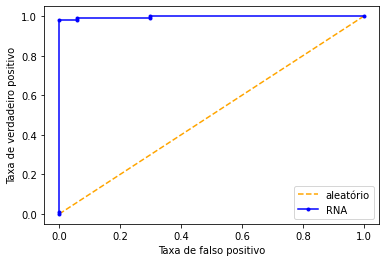

In [61]:
printAUROC(y,yhat_probs)

In [62]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y,(yhat_probs > 0.5))

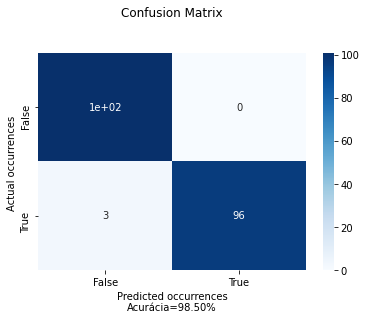

In [63]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAcurácia={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [64]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = yhat_probs

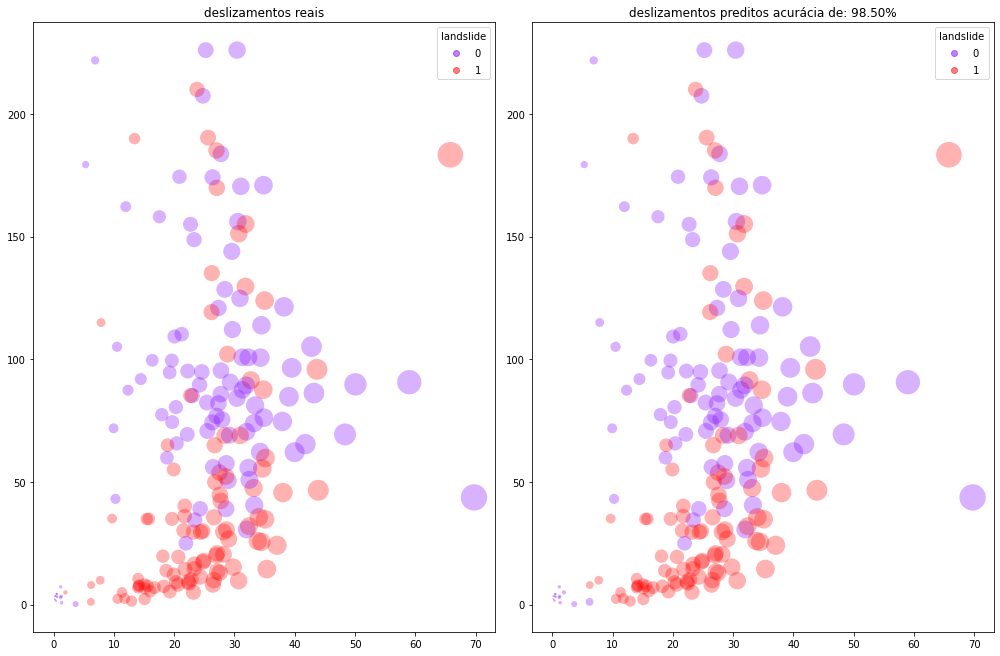

In [65]:
sizes = output_proprietario['slope']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [66]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [67]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [68]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Numero de Splits_stratified de X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)


In [69]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [97.5, 100.0, 97.5, 100.0, 97.5, 100.0, 95.0, 100.0, 97.5, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 95.0 %

Acurácia média: 98.5 %

Desvio Padrão: 1.7480147469502525


Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [70]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


In [71]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

Acurácia: 98.50%


In [72]:
NetworkPerformance(y, y_pred)

Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.996400
[[101   0]
 [  3  96]]


In [73]:
output_proprietario

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.002532
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.995376
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.000496
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.997809
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.202769
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,0.999991
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.000513
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.022406
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000075


ROC AUC=0.996


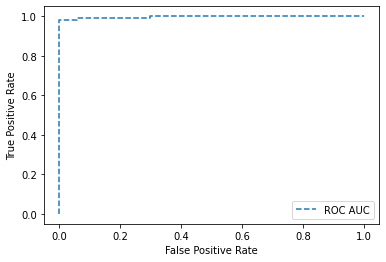

In [74]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

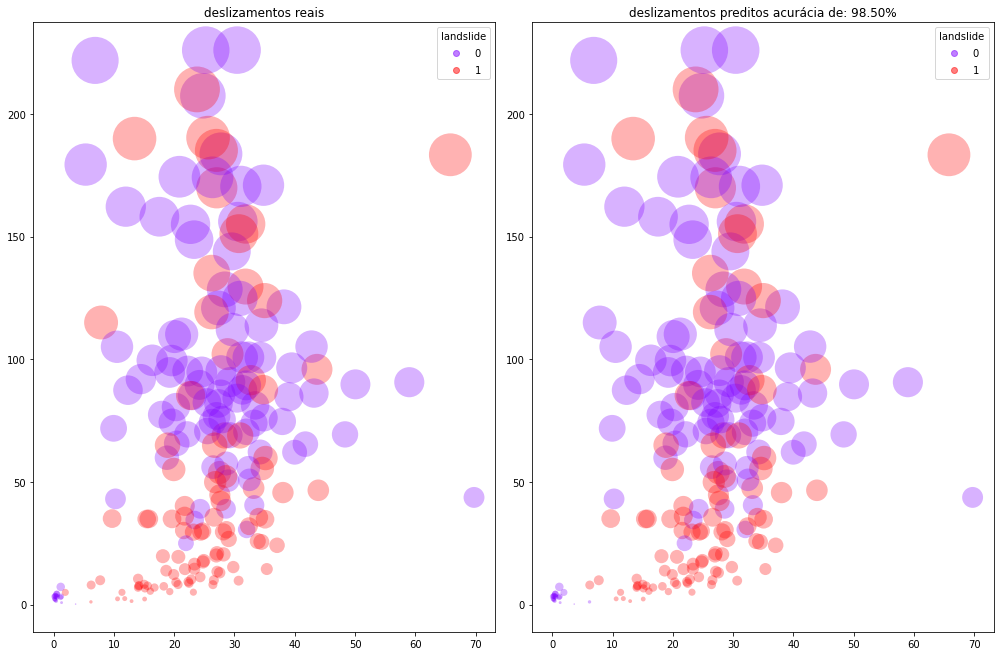

In [75]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)


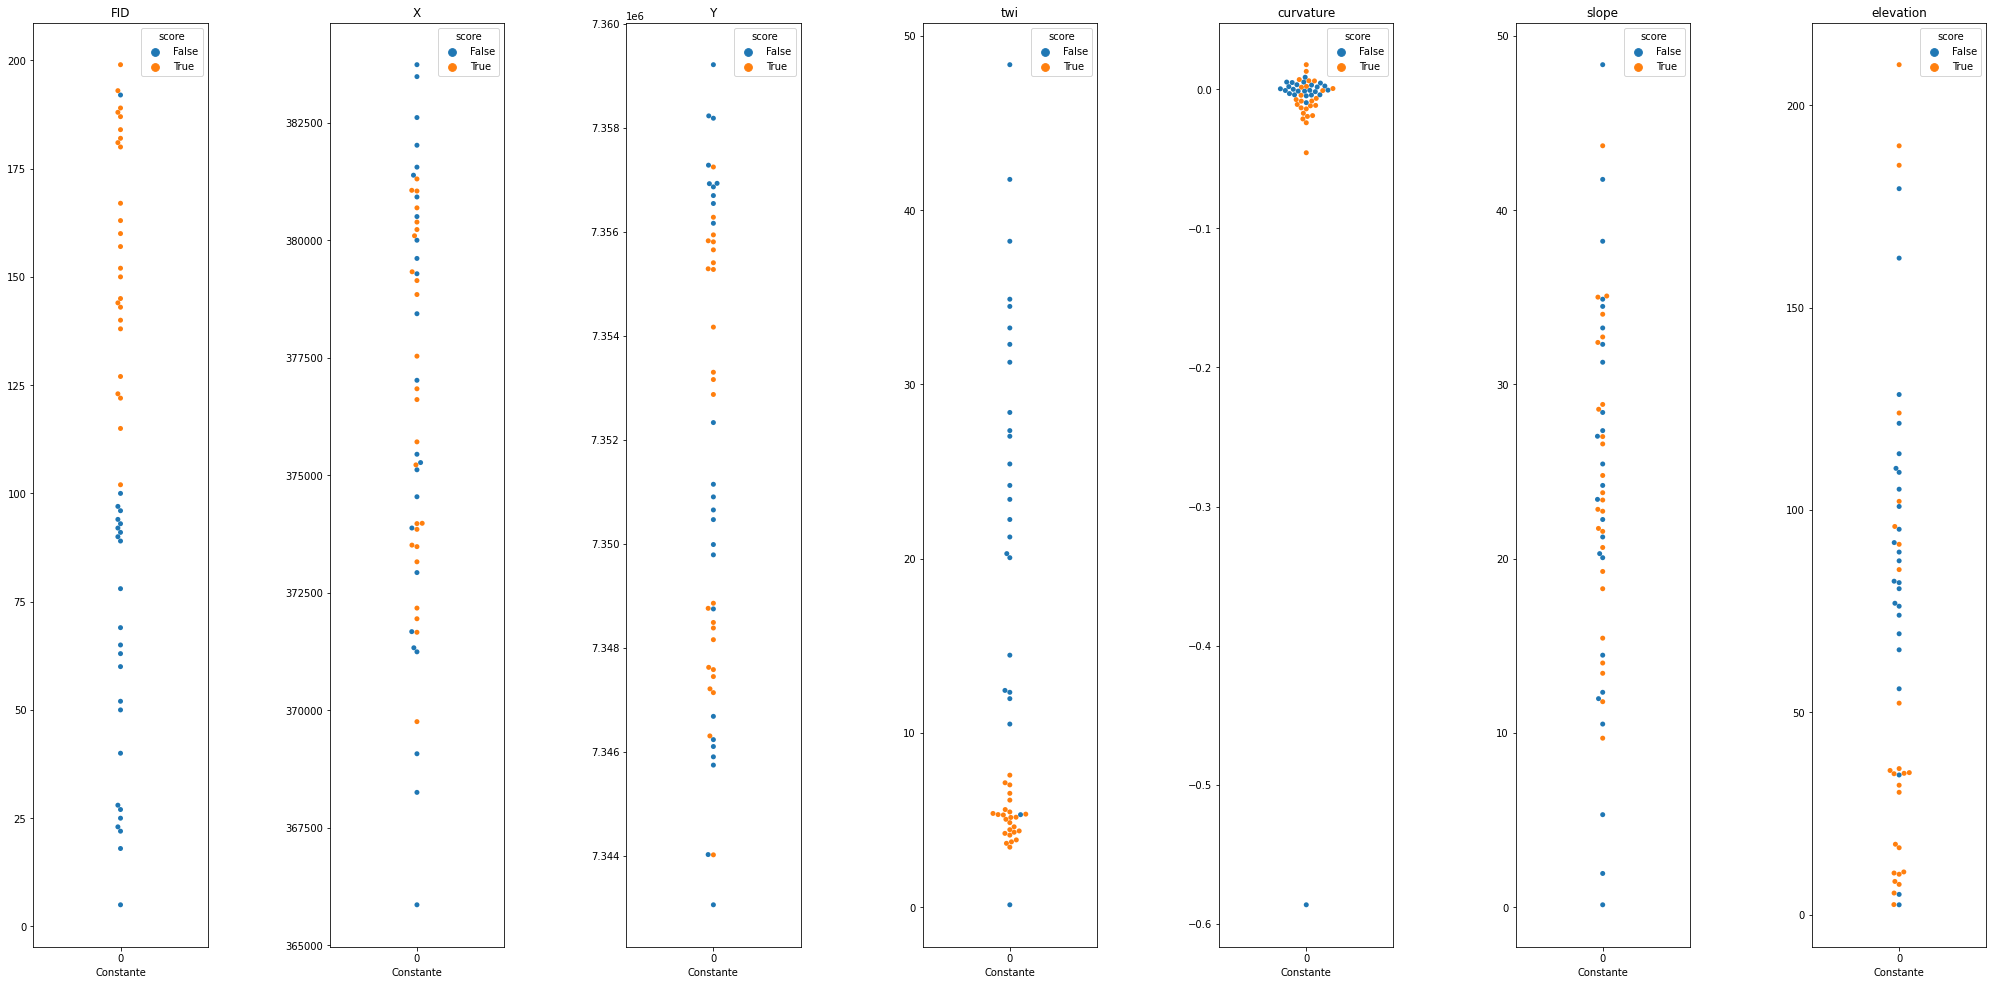

In [76]:
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [77]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

In [78]:
end = datetime.datetime.now()
print(end-start)
#quit()

0:54:38.535800


### Keras neural network
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [79]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [80]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [81]:
#{'num_hidden_layers': 1, 'num_units': 4, 'dropout_rate': 0.5, 'learning_rate': 0.004682800657889146}       

In [82]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [83]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [84]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
20/20 [==============================] - 1s 1ms/step - loss: 0.7361 - accuracy: 0.4898
Epoch 2/500
20/20 [==============================] - 0s 1ms/step - loss: 0.7079 - accuracy: 0.5204
Epoch 3/500
20/20 [==============================] - 0s 1ms/step - loss: 0.7132 - accuracy: 0.5714
Epoch 4/500
20/20 [==============================] - 0s 1ms/step - loss: 0.7082 - accuracy: 0.5306
Epoch 5/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6766 - accuracy: 0.5816
Epoch 6/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6728 - accuracy: 0.5408
Epoch 7/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6556 - accuracy: 0.6633
Epoch 8/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6602 - accuracy: 0.6327
Epoch 9/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6379 - accuracy: 0.6735
Epoch 10/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6386 - accuracy: 0.6939
Epoch 11/

20/20 [==============================] - 0s 1ms/step - loss: 0.2259 - accuracy: 0.9592
Epoch 84/500
20/20 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.9694
Epoch 85/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1957 - accuracy: 0.9388
Epoch 86/500
20/20 [==============================] - 0s 1ms/step - loss: 0.2009 - accuracy: 0.9694
Epoch 87/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1777 - accuracy: 0.9592
Epoch 88/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1811 - accuracy: 0.9592
Epoch 89/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1649 - accuracy: 0.9286
Epoch 90/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9694
Epoch 91/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1994 - accuracy: 0.9592
Epoch 92/500
20/20 [==============================] - 0s 1ms/step - loss: 0.2055 - accuracy: 0.9694
Epoch 93/500


20/20 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9592
Epoch 165/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1117 - accuracy: 0.9694
Epoch 166/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1138 - accuracy: 0.9694
Epoch 167/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0850 - accuracy: 0.9796
Epoch 168/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0734 - accuracy: 0.9796
Epoch 169/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1040 - accuracy: 0.9490
Epoch 170/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0866 - accuracy: 0.9898
Epoch 171/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0566 - accuracy: 0.9796
Epoch 172/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0774 - accuracy: 0.9694
Epoch 173/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.9898
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.0742 - accuracy: 0.9796
Epoch 246/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.9898
Epoch 247/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9796
Epoch 248/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9694
Epoch 249/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0732 - accuracy: 0.9796
Epoch 250/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.9694
Epoch 251/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0602 - accuracy: 0.9796
Epoch 252/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.9694
Epoch 253/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0738 - accuracy: 0.9796
Epoch 254/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9796
Epoc

20/20 [==============================] - 0s 1ms/step - loss: 0.0555 - accuracy: 0.9796
Epoch 327/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9898
Epoch 328/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0415 - accuracy: 0.9796
Epoch 329/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.9898
Epoch 330/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0439 - accuracy: 0.9796
Epoch 331/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0596 - accuracy: 0.9796
Epoch 332/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0373 - accuracy: 0.9898
Epoch 333/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.9898
Epoch 334/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0552 - accuracy: 0.9796
Epoch 335/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9796
Epoc

20/20 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9898
Epoch 408/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0352 - accuracy: 0.9898
Epoch 409/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0358 - accuracy: 0.9898
Epoch 410/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0402 - accuracy: 1.0000
Epoch 411/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0382 - accuracy: 0.9898
Epoch 412/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0253 - accuracy: 1.0000
Epoch 413/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0431 - accuracy: 0.9898
Epoch 414/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.9898
Epoch 415/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0451 - accuracy: 0.9796
Epoch 416/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 1.0000
Epoc

20/20 [==============================] - 0s 1ms/step - loss: 0.0259 - accuracy: 1.0000
Epoch 489/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0555 - accuracy: 0.9796
Epoch 490/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0289 - accuracy: 0.9898
Epoch 491/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0432 - accuracy: 0.9898
Epoch 492/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0257 - accuracy: 1.0000
Epoch 493/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0370 - accuracy: 0.9898
Epoch 494/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0295 - accuracy: 0.9898
Epoch 495/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0278 - accuracy: 1.0000
Epoch 496/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0215 - accuracy: 1.0000
Epoch 497/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.9898
Epoc

In [85]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 155


In [86]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 2ms/step - loss: 0.0992 - accuracy: 0.9667
Accuracy: 96.67


In [87]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 1.0000
Epoch 2/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0420 - accuracy: 0.9898
Epoch 3/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9898
Epoch 4/155
4/4 [==============================] - 0s 4ms/step - loss: 0.0380 - accuracy: 0.9796
Epoch 5/155
4/4 [==============================] - 0s 3ms/step - loss: 0.0468 - accuracy: 0.9898
Epoch 6/155
4/4 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.9898
Epoch 7/155
4/4 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 1.0000
Epoch 8/155
4/4 [==============================] - 0s 4ms/step - loss: 0.0303 - accuracy: 1.0000
Epoch 9/155
4/4 [==============================] - 0s 3ms/step - loss: 0.0205 - accuracy: 1.0000
Epoch 10/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 1.0000
Epoch 11/155
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0327 - accuracy: 0.9898
Epoch 85/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9898
Epoch 86/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9898
Epoch 87/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9694
Epoch 88/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 0.9898
Epoch 89/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9898
Epoch 90/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9898
Epoch 91/155
4/4 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 1.0000
Epoch 92/155
4/4 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 1.0000
Epoch 93/155
4/4 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 1.0000
Epoch 94/155
4/4 [===============

In [88]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 3ms/step - loss: 0.0929 - accuracy: 0.9667
Accuracy: 96.67


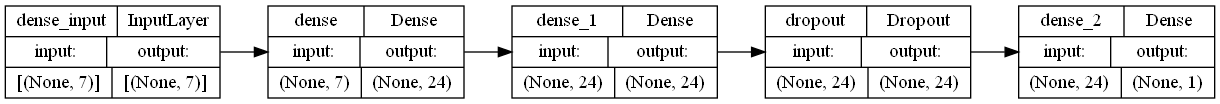

In [89]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

In [90]:
if accuracy >= .80:
    print('ótima acurácia, rede salva!')
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('acurácia abaixo de .85')

ótima acurácia, rede salva!
INFO:tensorflow:Assets written to: bestANN\suscetibilidadeKeras_guaruja.pkl\assets


#### Assessment

In [91]:
#X = dataset.drop('class',axis=1)
#y = dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

In [92]:
#X

In [93]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Numero de Splits de X:  10 

2/2 [==============================] - 0s 2ms/step


In [94]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [100.0, 100.0, 95.0, 100.0, 100.0, 100.0, 97.5, 97.5, 100.0, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 95.0 %

Acurácia média: 99.0 %

Desvio Padrão: 1.7480147469502525


In [95]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

2/2 [==============================] - 0s 4ms/step
Acurácia: 96.67%


In [96]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

4/4 [==============================] - 0s 1ms/step
Acurácia: 100.00%


In [97]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

2/2 [==============================] - 0s 2ms/step
Acurácia: 100.00%


In [98]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

7/7 [==============================] - 0s 1ms/step
Acurácia: 99.00%


In [99]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.000030
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.999967
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.000034
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.999995
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.020025
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,1.000000
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.000001
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.002089
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000002


ROC AUC=0.998


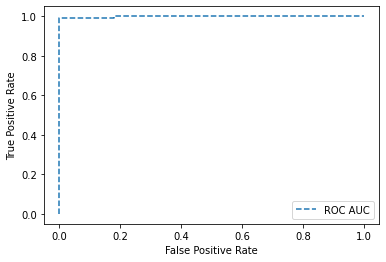

In [100]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

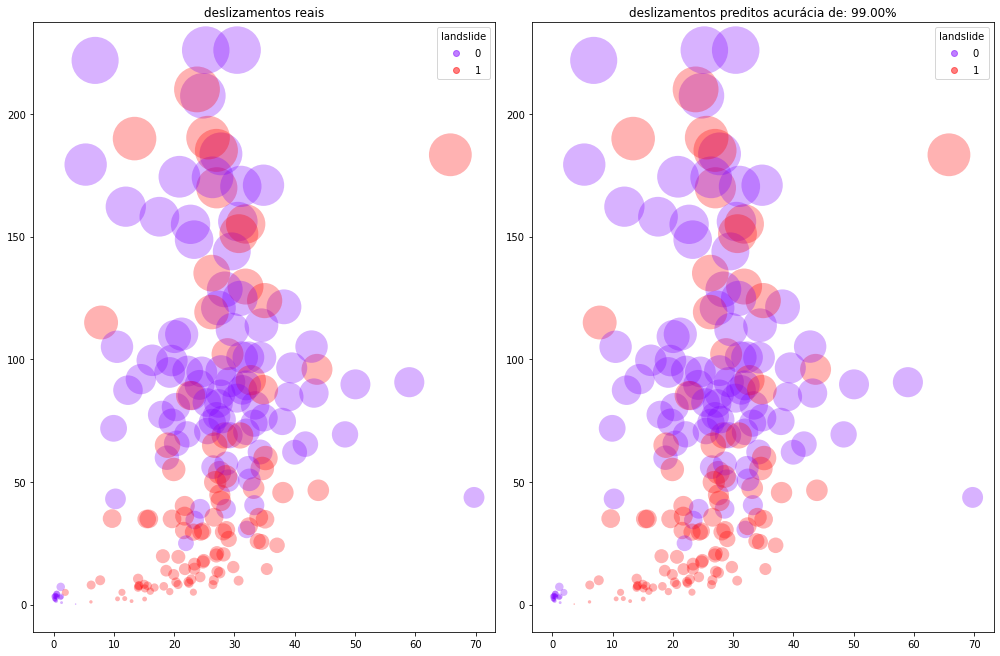

In [101]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)


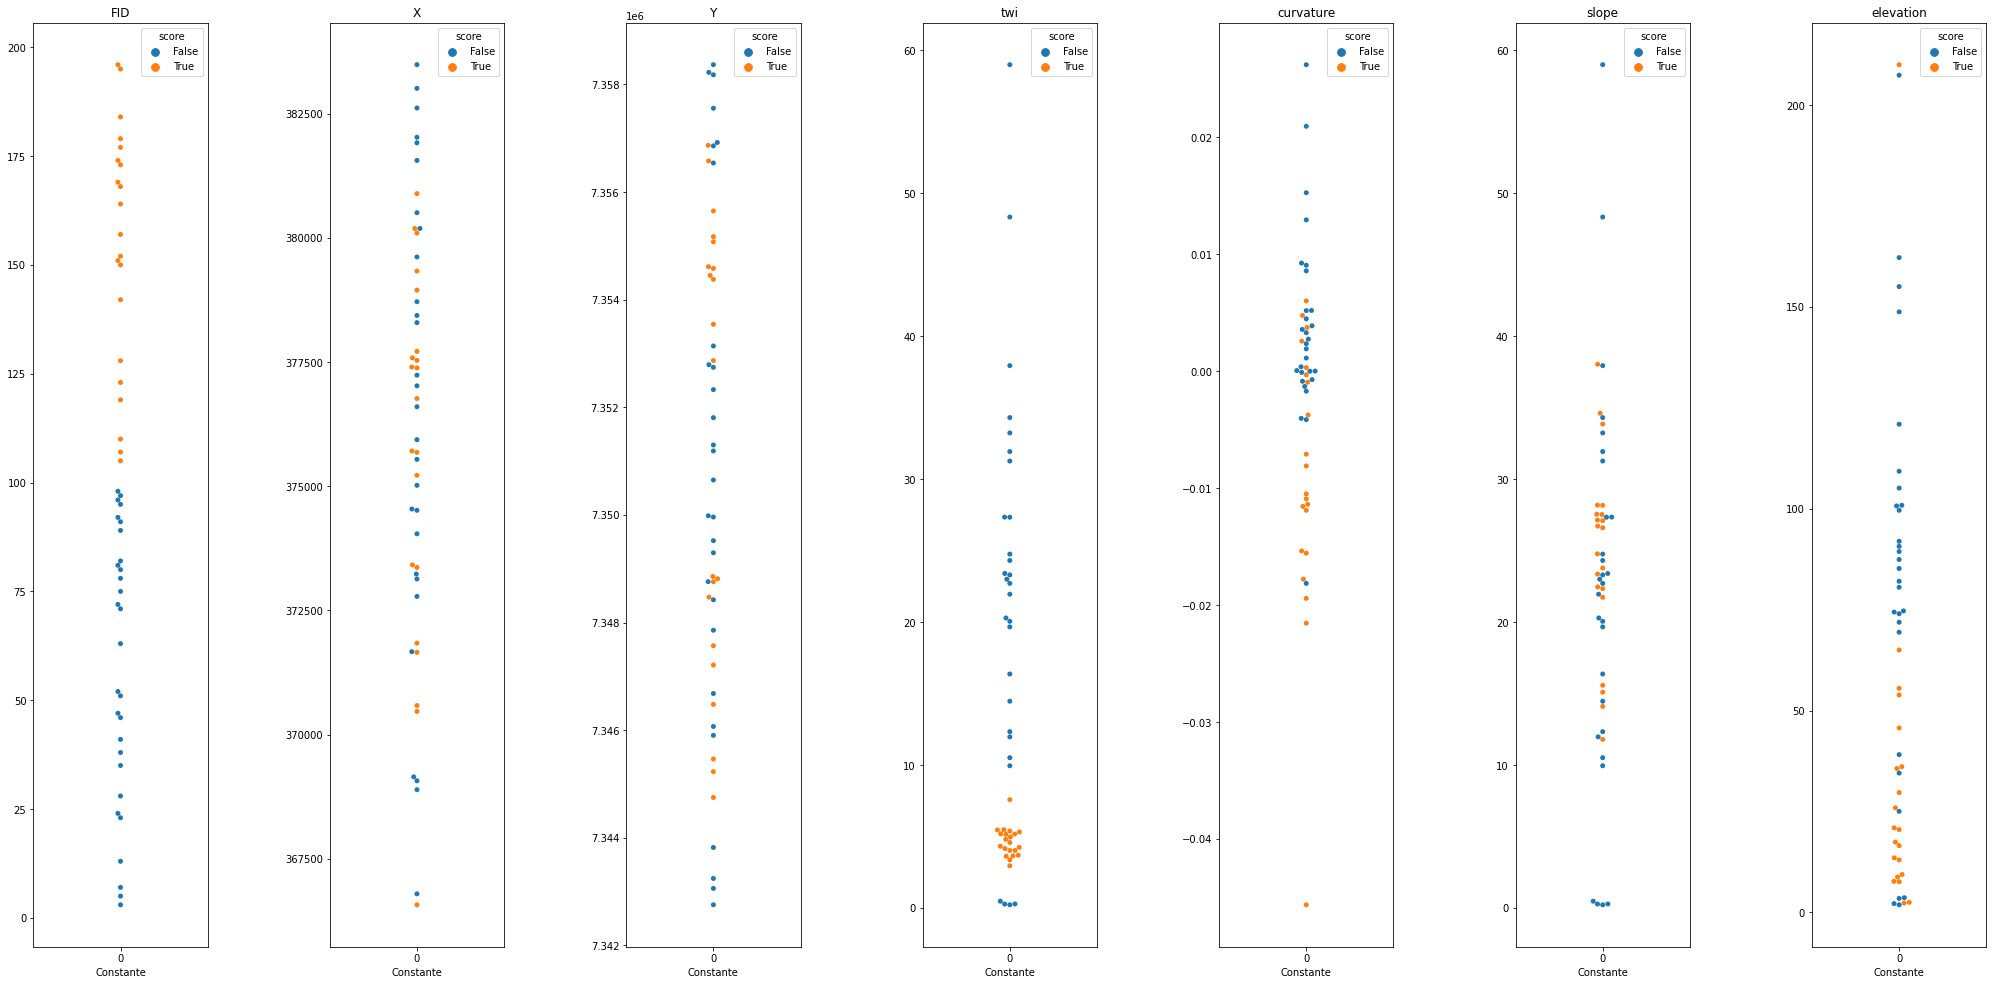

In [102]:
dataSet = output_keras.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [103]:
end = datetime.datetime.now()
print(end-start)

0:58:29.598425


## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/